This code uses Principal Component Analysis (to reduce dimensionality) and k-means clustering to group similar 'hit' songs together.

In [87]:
# Import Libraries

import pandas as pd
import requests
import io
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [88]:
# Downloading the csv file from our GitHub repo

url = "https://raw.githubusercontent.com/Jingxue-24/QM2-team9/main/merged.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Previewing data

print (df.head())
print(df.columns)


                                 Name  ... Time_signature
0          Bridge Over Troubled Water  ...              4
1      (They Long To Be) Close To You  ...              4
2  American Woman - 7" Single Version  ...              4
3                War - Single Version  ...              4
4       Ain't No Mountain High Enough  ...              4

[5 rows x 17 columns]
Index(['Name', 'Album', 'Artist', 'Popular_date', 'Release_date', 'Length',
       'Popularity', 'Danceability', 'Acousticness', 'Danceability.1',
       'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness',
       'Tempo', 'Time_signature'],
      dtype='object')


All works well. Moving on to prepping the data for PCA.

In [89]:
df.drop(['Name', 'Album', 'Artist','Popular_date','Release_date', 'Popularity', 'Danceability.1', 'Liveness'], axis=1, inplace=True)
print(df.columns)  
print(df.head()) 
df.dropna(inplace=True)

Index(['Length', 'Danceability', 'Acousticness', 'Energy', 'Instrumentalness',
       'Loudness', 'Speechiness', 'Tempo', 'Time_signature'],
      dtype='object')
   Length  Danceability  Acousticness  ...  Speechiness    Tempo  Time_signature
0  293120         0.149        0.8220  ...       0.0323   79.764               4
1  276000         0.543        0.6690  ...       0.0344   89.078               4
2  231640         0.538        0.0424  ...       0.0375   93.077               4
3  200960         0.591        0.0677  ...       0.1920  109.481               4
4  215200         0.393        0.1910  ...       0.0448   98.757               4

[5 rows x 9 columns]


All works well. Moving on to Kaiser-Meyer-Olkin test for suitability of data for PCA.

In [ ]:
# KMO test
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df)
kmo_model # = 0.5958992986526002 

Not a great KMO value - "miserable". We will have to discuss this in the website. 

TypeError: ignored

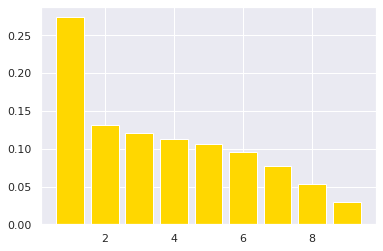

In [94]:
from sklearn.preprocessing import StandardScaler
#Standardising data
std_df = StandardScaler().fit_transform(df) #normalizing

#PCA
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(std_df)

#Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

#Putting it in a dataframe
PCA_components = pd.DataFrame(principalComponents)

First principal component explains over 25% of the variance. Second explains approximately 13%.

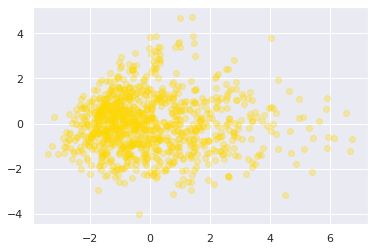

In [95]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel=('PCA 1')
plt.ylabel=('PCA 2')
plt.show()

Now, we need to use k-means to see how many clusters there actually are. 

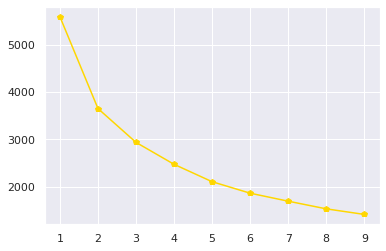

In [96]:
# Clustering - seeing exactly how many there are. 
inertias = []

for k in range(1,10):
  model = KMeans(n_clusters=k)

  model.fit(PCA_components.iloc[:,:3])

  inertias.append(model.inertia_)

plt.plot(range(1,10), inertias, '-p', color='gold')
plt.show()

Elbow method suggests 3 groupings.

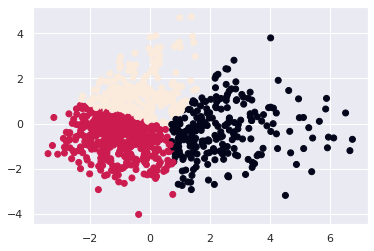

In [97]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])
labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

In [98]:
# Getting information about clusters to name them.

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(std_df)

kmeans = pd.DataFrame(data=y_kmeans, dtype=int)
kmeans.columns=['k_cluster']
print(kmeans.shape)
kmeans.head()

(989, 1)


,k_cluster
0,2
1,2
2,1
3,1
4,1


In [99]:
# Downloading the original full csv file from our GitHub repo

url = "https://raw.githubusercontent.com/Jingxue-24/QM2-team9/main/merged.csv"
download = requests.get(url).content
full_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
full_df.drop(['Release_date','Popularity', 'Danceability.1'], axis=1, inplace=True)
# Concatenating
df_cluster = pd.concat([full_df, kmeans], axis=1)
print(df_cluster.shape)
df_cluster.head() # it works - have the cluster with the name of the song. 

(989, 15)


,Name,Album,Artist,Popular_date,Length,Danceability,Acousticness,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time_signature,k_cluster
0,Bridge Over Troubled Water,Bridge Over Troubled Water,Simon & Garfunkel,1970,293120,0.149,0.8220,0.206,0.000649,0.115,-13.888,0.0323,79.764,4,2
1,(They Long To Be) Close To You,Close To You,Carpenters,1970,276000,0.543,0.6690,0.241,0.000063,0.121,-14.590,0.0344,89.078,4,2
2,"American Woman - 7"" Single Version",Platinum & Gold Collection,The Guess Who,1970,231640,0.538,0.0424,0.841,0.001780,0.312,-7.547,0.0375,93.077,4,1
3,War - Single Version,Superstar Series Vol. 3,Edwin Starr,1970,200960,0.591,0.0677,0.781,0.000000,0.294,-9.680,0.1920,109.481,4,1
4,Ain't No Mountain High Enough,Diamond Diana: The Legacy Collection,Diana Ross,1970,215200,0.393,0.1910,0.792,0.003640,0.376,-5.076,0.0448,98.757,4,1


In [100]:
# Check for null
df_cluster.isnull().sum() #no nulls!

#Number of songs per cluster
df_cluster['k_cluster'].value_counts()

# Statistical distribution of the data in each column, for each cluster 
df_cluster.groupby("k_cluster").describe()

Popular_date                                  ... Time_signature               
                 count         mean        std     min  ...            25%  50%  75%  max
k_cluster                                               ...                              
0                 30.0  1991.166667  13.009501  1973.0  ...            3.0  3.0  3.0  3.0
1                637.0  1999.015699  13.449875  1970.0  ...            4.0  4.0  4.0  5.0
2                322.0  1986.341615  12.531135  1970.0  ...            4.0  4.0  4.0  4.0

[3 rows x 88 columns]

In [101]:
# Updated datasets
cluster_zero = df_cluster.loc[df_cluster['k_cluster']==0]
cluster_one = df_cluster.loc[df_cluster['k_cluster']==1]
cluster_two = df_cluster.loc[df_cluster['k_cluster']==2]

# Exporting
cluster_zero.to_csv('cluster_zero.csv', index=False, header=True)
cluster_one.to_csv('cluster_one.csv', index=False, header=True)
cluster_two.to_csv('cluster_two.csv', index=False, header=True)
df_cluster.to_csv('cluster_all.csv', index=False, header=True)